# Biased Likelihood Integrals and Samples
*David Thomas 2017/03/10*

Contents:
- [Background](#Background)
- [Sample Size Sensitivity](#Sample-Size-Sensitivity)
- [Single Integral Convergence](#Single-Integral-Convergence)
- [Individual Biased Samples](#Individual-Biased-Samples)
- [Large Contributors](#Large-Contributors)
- [Changes at Higher Posterior Points](#Changes-At-Higher-Posterior-Points)

# Background

We have observed strange posterior sample behavior from our likelihood calculation and use this notebook to examine the individual integrals. We begin by fixing a set of hyperparameters and generating the distribution of integrals in the log likelihood calculation.

In [68]:
% load_ext autoreload
% autoreload 2
% matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
from bigmali.grid import Grid
from bigmali.likelihood import BiasedLikelihood
from bigmali.prior import TinkerPrior
from bigmali.hyperparameter import get

In [71]:
import pandas as pd

data = pd.read_csv('/Users/user/Code/PanglossNotebooks/MassLuminosityProject/mock_data.csv')
grid = Grid()
prior = TinkerPrior(grid)
lum_obs = data.lum_obs[:10 ** 4]
z = data.z[:10 ** 4]
bl = BiasedLikelihood(grid, prior, lum_obs, z)

# Sample Size Sensitivity

Below we collect the values for the integrals corresponding to a subset of $10^4$ galaxies (with corresponding lum_obs and z). We collect these values when 100, 1,000, and 10,000 draws from the biased distribution are used in order to compare how **sensitive the integrals are to the number of biased distribution samples**. We also can examine the runtime and see that from 1,000 to 10,000 samples the runtime grows close to linearly.

In [25]:
hypers = get()
%time vals100 = map(lambda lum_obs,z: bl.single_integral(*(hypers + [lum_obs, z]), nsamples=100), lum_obs, z)
%time vals1000 = map(lambda lum_obs,z: bl.single_integral(*(hypers + [lum_obs, z]), nsamples=1000), lum_obs, z)
%time vals10000 = map(lambda lum_obs,z: bl.single_integral(*(hypers + [lum_obs, z]), nsamples=10000), lum_obs, z)

CPU times: user 2.89 s, sys: 23.3 ms, total: 2.91 s
Wall time: 2.94 s
CPU times: user 7.71 s, sys: 12 ms, total: 7.72 s
Wall time: 7.73 s
CPU times: user 55.1 s, sys: 69.7 ms, total: 55.2 s
Wall time: 55.3 s


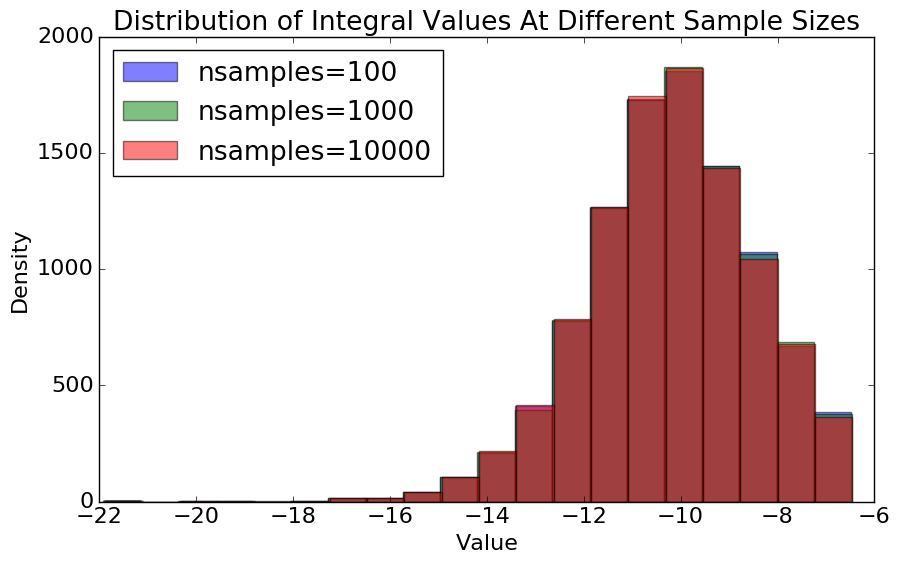

In [42]:
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

plt.hist(vals100, alpha=0.5, label='nsamples=100', bins=20)
plt.hist(vals1000, alpha=0.5, label='nsamples=1000', bins=20)
plt.hist(vals10000, alpha=0.5, label='nsamples=10000', bins=20)
plt.title('Distribution of Integral Values At Different Sample Sizes')
plt.ylabel('Density')
plt.xlabel('Value')
plt.gcf().set_size_inches((10,6))
plt.legend(loc=2);

# Single Integral Convergence

This result is a bit surprising. It suggests we may not need many samples to characterize an integral. To examine this further let's **isolate a single integral** and see how its value changes as we increase the number of samples. We do this for three different galaxies to limit the chance we are making conclusions on outliers

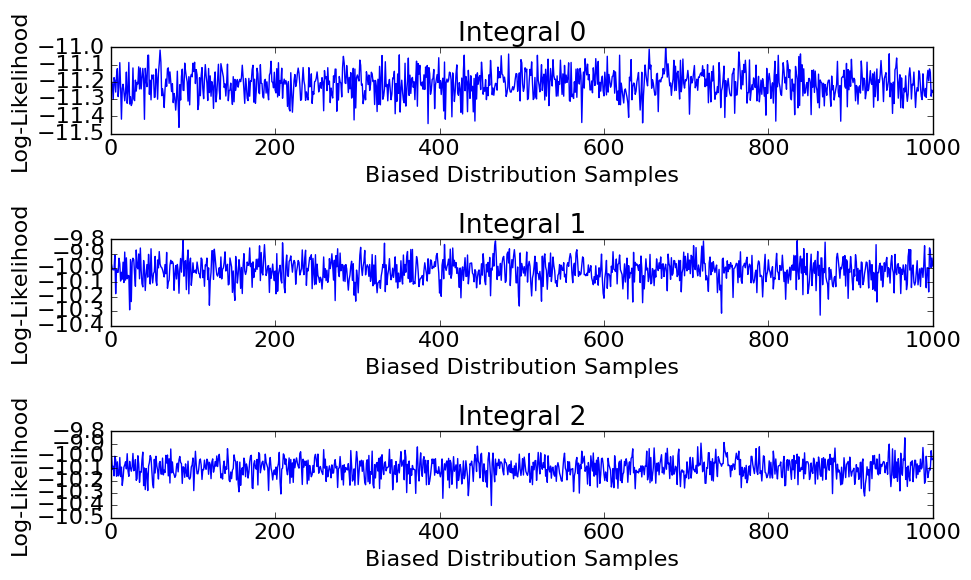

In [109]:
single_lum_obs0 = lum_obs[0]
single_z0 = z[0]
single_lum_obs1 = lum_obs[100]
single_z1 = z[100]
single_lum_obs2 = lum_obs[5000]
single_z2 = z[5000]
space = np.linspace(1, 1000, 1000)
single_vals = np.zeros((1000,3))
for i, nsamples in enumerate(space):
    single_vals[i,0] = bl.single_integral(*(hypers + [single_lum_obs0, single_z0]))
    single_vals[i,1] = bl.single_integral(*(hypers + [single_lum_obs1, single_z1]))
    single_vals[i,2] = bl.single_integral(*(hypers + [single_lum_obs2, single_z2]))
    
plt.subplot(311)
plt.plot(space, single_vals[:,0])
plt.title('Integral 0')
plt.xlabel('Biased Distribution Samples')
plt.ylabel('Log-Likelihood')

plt.subplot(312)
plt.plot(space, single_vals[:,1])
plt.title('Integral 1')
plt.xlabel('Biased Distribution Samples')
plt.ylabel('Log-Likelihood')

plt.subplot(313)
plt.plot(space, single_vals[:,2])
plt.title('Integral 2')
plt.xlabel('Biased Distribution Samples')
plt.ylabel('Log-Likelihood')
plt.gcf().set_size_inches((10,6))
plt.tight_layout()

# Individual Biased Samples

A few things are concerning about these results. First, they bobble within a window and never converge. Second, even one sample provides a reasonable approximation. We will need to start examining the **individual weights of the biased samples**. Below we get the internal weights used in a single integral. The keys of the dataframe correspond to the distributions here:


\begin{align*}
v1 &= \ln P(L_{obs}|L^s, \sigma_L)\\
v2 &= \ln P(L^s|M^s, z, \alpha, S)\\
v3 &= \ln P(M^s|z)\\
v4 &= \ln Q(L^s|L_{obs}, \sigma_L)\\
v5 &= \ln Q(M^s|L^s, z, \alpha, S_M)\\
out &= logsumexp(v1 + v2 + v3 - v4 - v5) - log(nsamples)\\
\end{align*}

- v1 values pass sanity check
- v2 values pass sanity check
- v3 values pass sanity check
- v4 values pass sanity check
- v5 values pass sanity check

In [79]:
single_lum_obs0 = lum_obs[0]
single_z0 = z[0]
internals = bl.single_integral_samples_and_weights(*(hypers + [single_lum_obs0, single_z0]))
print single_lum_obs0
print single_z0
internals

13748.7935573
2.07709


,lum_samples,mu_mass,mass_samples,mu_lum,v1,v2,v3,v4,v5,out
0,14035.575642,2.074165e+11,1.952559e+11,13731.433262,-7.537149,-8.626620,-28.807932,-7.557793,-26.800461,-11.285231
1,14175.528071,2.131704e+11,1.352225e+12,27698.886782,-7.638769,-17.727312,-33.134140,-7.669335,-30.895619,-11.285231
2,14074.452676,2.090048e+11,6.254595e+11,20943.311962,-7.561520,-11.823416,-31.343171,-7.584930,-28.723536,-11.285231
3,13051.239089,1.697284e+11,9.788367e+10,10689.907120,-7.994128,-9.352014,-27.367470,-7.942060,-26.299559,-11.285231
4,14133.777575,2.114434e+11,8.995077e+10,10367.272808,-7.604446,-10.571723,-27.193491,-7.632062,-26.485912,-11.285231
5,13443.870696,1.841854e+11,2.217755e+11,14380.406497,-7.552514,-8.665789,-29.077917,-7.530086,-26.947356,-11.285231
6,14411.801070,2.231133e+11,1.969898e+12,31747.499868,-7.895525,-21.292894,-34.053489,-7.942621,-32.115103,-11.285231
7,13806.084836,1.981974e+11,7.151826e+10,9540.119042,-7.455371,-11.370847,-26.723765,-7.459529,-26.452047,-11.285231
8,14591.984576,2.308911e+11,4.264627e+11,18227.964223,-8.160470,-9.659634,-30.491133,-8.219991,-27.817881,-11.285231
9,13925.771735,2.029721e+11,3.794615e+10,7581.375816,-7.484630,-16.107135,-25.441055,-7.497420,-26.941551,-11.285231


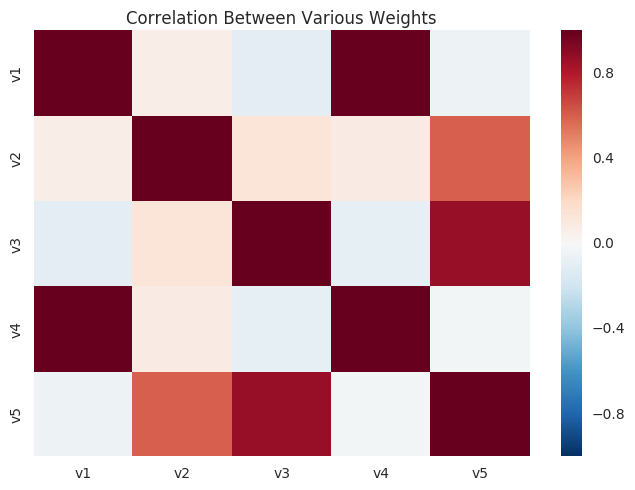

In [130]:
import seaborn as sns

cols = ['v1','v2','v3','v4','v5']
plt.title('Correlation Between Various Weights')
sns.heatmap(internals[cols].corr(), xticklabels=cols, yticklabels=cols);

# Large Contributors

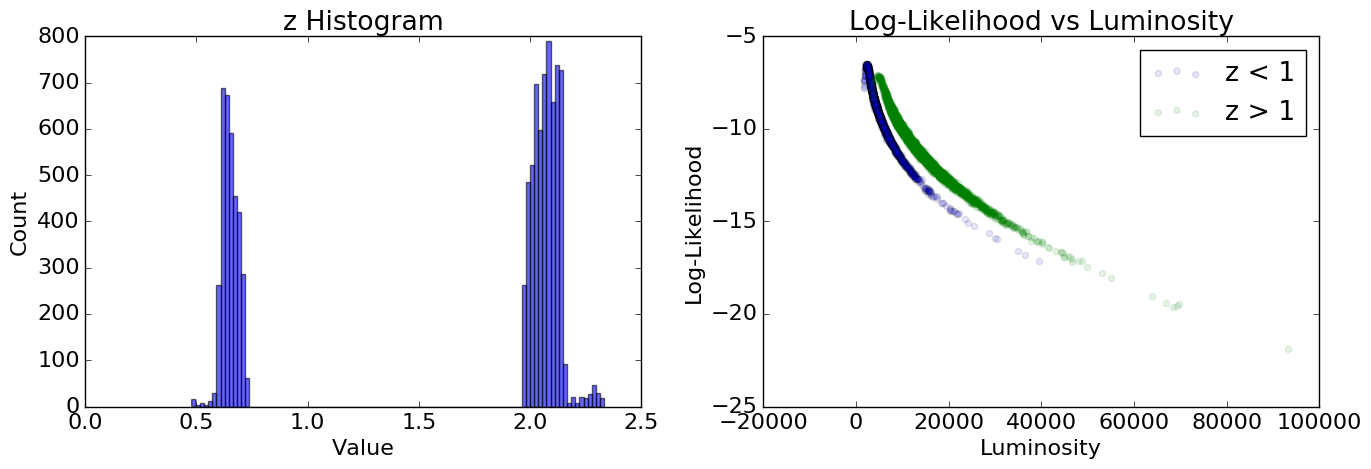

In [120]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}


z_z1 = z[z < 1]
z_z2 = z[z > 1]
lum_obs_z1 = lum_obs[z < 1]
lum_obs_z2 = lum_obs[z > 1]
vals100_z1 = np.array(vals100)[np.where(z < 1)]
vals100_z2 = np.array(vals100)[np.where(z > 1)]

plt.subplot(121)
plt.hist(z, bins=100, alpha=0.6)
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('z Histogram')

plt.subplot(122)
plt.scatter(lum_obs_z1, vals100_z1, label='z < 1', alpha=0.1)
plt.scatter(lum_obs_z2, vals100_z2, label='z > 1', alpha=0.1, color='green')
plt.legend()
plt.ylabel('Log-Likelihood')
plt.xlabel('Luminosity')
plt.title('Log-Likelihood vs Luminosity')

plt.gcf().set_size_inches((14,5))
plt.tight_layout()

Hmmm ... have to think about this a bit.

# Changes At Higher Posterior Points

The next question I want to explore is: How do our biased distributions change as we **move towards more probable posterior samples**?

In [133]:
hypers2 = hypers
hypers2[-1] = 1
internals2 = bl.single_integral_samples_and_weights(*(hypers2 + [single_lum_obs0, single_z0]))

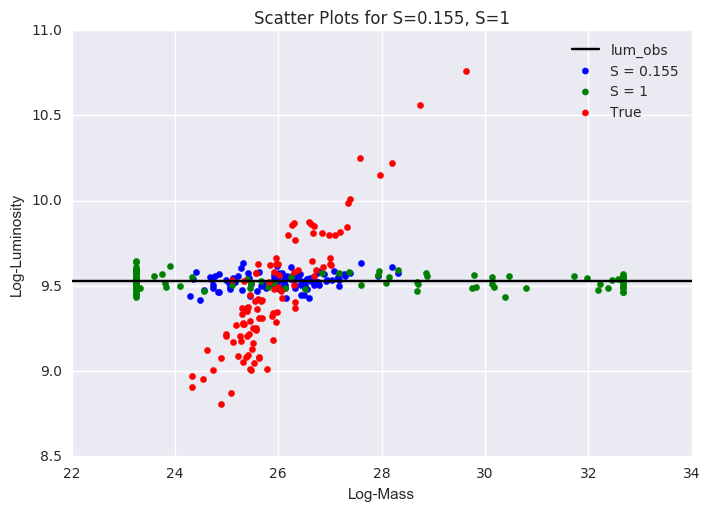

In [141]:
plt.scatter(np.log(internals['mass_samples']), np.log(internals['lum_samples']), color='blue', label='S = 0.155') 
plt.scatter(np.log(internals2['mass_samples']), np.log(internals2['lum_samples']), color='green', label='S = 1') 
plt.scatter(np.log(data['mass'][:100]), np.log(data['lum'][:100]), color='red', label='True') 
plt.gca().axhline(np.log(single_lum_obs0), color='k', label='lum_obs')
plt.title('Scatter Plots for S=0.155, S=1')
plt.ylabel('Log-Luminosity')
plt.xlabel('Log-Mass')
plt.legend();

Need to think about handling out of bounds of prior more gracefully. Look forward to discussing with Phil ...